# KUBIG 24S NLP Basic Week 3

## Preview

### 19기 정종락

$$
\\
$$

## **예습 코드**

[실습명: 어텐션을 사용한 인공 신경망 기계 번역]
- http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용.

- 이 노트북은 스페인어를 영어로 변역하기 위해 시퀀스-투-시퀀스 (seq2seq) 모델을 훈련시킵니다. 또한 이 노트북은 시퀀스-투-시퀀스 모델의 사전적인 지식을 요구하는 심화된 예제입니다.

- 이 노트북에서 신경망 기계 번역 모델을 훈련하면 *"¿todavia estan en casa?"*와 같은 스페인 문장을 입력했을 때 *"are you still at home?"*처럼 영어로 번역된 문장을 얻을 수 있을 것입니다

- 아래의 플롯은 모델을 훈련하는 동안에 입력 문장의 각 단어가 갖고 있는 모델 어텐션을 시각화하여 보여준 것입니다:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">


In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### 데이터셋 준비

http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용할 것입니다. 이 데이터셋은 언어 번역의 쌍이 다음과 같은 형식으로 포함되어 있습니다:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

다양한 언어가 이용가능하지만 이 예제에서는 영어-스페인 데이터셋을 사용할 것입니다. 편의를 위해서 이 데이터셋의 복사본을 Google Cloud에서 호스팅 했지만 직접 다운로드해야 합니다. 데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 *start*와 *end* 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [73]:
path_to_zip

'/root/.keras/datasets/spa-eng.zip'

In [74]:
path_to_file

'/root/.keras/datasets/spa-eng/spa.txt'

In [72]:
# 파일을 다운로드합니다.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 1s 0us/step


In [ ]:
# 유니코드 파일을 아스키 코드 파일로 변환합니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. 문장에 있는 억양을 제거합니다.
# 2. 불필요한 문자를 제거하여 문장을 정리합니다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 스페인어]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding ='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples = None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

###  더 빠른 실행을 위해 데이터셋의 크기 제한하기(선택)

10만개 이상의 문장이 있는 완전한 데이터셋을 훈련하는 것은 오랜 시간이 걸립니다. 훈련 속도를 높이기 위해서 데이터셋의 크기를 3만개의 문장으로 제한합니다. (물론, 번역의 질은 데이터가 적어질수록 저하됩니다):

In [ ]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
65 ----> solo
7 ----> es
21 ----> una
2345 ----> corazonada
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
10 ----> it
11 ----> s
70 ----> just
9 ----> a
1391 ----> hunch
3 ----> .
2 ----> <end>


### tf.data 데이터셋 생성하기

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 모델과 디코더 모델 쓰기

어텐션(attention)을 가진 인코더-디코더 모델을 수행합니다. 어텐션(attention)은 TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt)에서 읽을 수 있습니다. 이 예제는 더 최신의 API 집합을 사용합니다. 이 노트북은 seq2seq 튜토리얼로부터 [어텐션 방정식](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)을 수행합니다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습입니다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용됩니다. 아래의 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5)에서 나온 어텐션 메커니즘의 예시입니다.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

입력은 *(batch_size, max_length, hidden_size)*의 형태로 이루어진 인코더 결과와 *(batch_size, hidden_size)*쌍으로 이루어진 인코더 은닉 상태(hidden state)를 제공하는 인코더 모델을 통해 입력됩니다.

아래의 공식은 위에서 사용한 방정식을 나타낸 것이다:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

이 튜토리얼은 인코더를 위해 [Bahdanau 어텐션](https://arxiv.org/pdf/1409.0473.pdf)을 사용합니다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의합니다:

* FC = 완전 연결(Dense)층
* EO = 인코더 결과
* H = 은닉 상태(hidden state)
* X = 디코더에 대한 입력

그리고 다음은 슈도코드입니다:

* `스코어(score)는 FC(tanh(FC(EO) + FC(H)))`로 계산합니다.
* `어텐션 가중치는 softmax(score, axis = 1)`로 계산합니다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 *(batch_size, max_length, hidden_size)*이기 때문에 *첫번째 축*을 적용합니다. `Max_length`은 입력의 길이입니다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있습니다.
* `컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)`로 계산합니다. 위와 같은 이유로 첫번째 축을 선택합니다.
* `임베딩 결과(embedding output)`는 디코더 X에 대한 입력이 임베딩층을 통과한 결과입니다.
* `병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))`와 같습니다.
* 그런 다음 병합된 벡터는 GRU에 주어집니다.

매 단계마다 모든 벡터의 형태는 코드내 주석에 명시되어 있습니다:

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
    # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
    # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
    # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
    query_with_time_axis = tf.expand_dims(query, 1)

    # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
    # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    attention_weights = tf.nn.softmax(score, axis=1)

    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션을 사용합니다.
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
    x = self.embedding(x)

    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 위에서 결합된 벡터를 GRU에 전달합니다.
    output, state = self.gru(x)

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
    output = tf.reshape(output, (-1, output.shape[2]))

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 최적화 함수와 손실 함수 정의하기

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 체크포인트 (객체 기반 저장)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 언어 모델 훈련하기

1. *인코더 결과*와 *인코더 은닉 상태(hidden state)*를 반환하는 *인코더*를 통해서 *입력*을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (*start 토큰*)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 *예측 값*과 *디코더 은닉 상태(hidden state)*를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 *교사 강요(teacher forcing)*를 사용합니다.
6. *교사 강요(teacher forcing)*는 *타겟 단어*가 디코더에 *다음 입력*으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]):
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6507
Epoch 1 Batch 100 Loss 2.2062
Epoch 1 Batch 200 Loss 1.8760
Epoch 1 Batch 300 Loss 1.6710
Epoch 1 Loss 2.0295
Time taken for 1 epoch 46.002403020858765 sec

Epoch 2 Batch 0 Loss 1.6629
Epoch 2 Batch 100 Loss 1.3805
Epoch 2 Batch 200 Loss 1.3588
Epoch 2 Batch 300 Loss 1.3102
Epoch 2 Loss 1.3994
Time taken for 1 epoch 27.977002143859863 sec

Epoch 3 Batch 0 Loss 1.1542
Epoch 3 Batch 100 Loss 1.0768
Epoch 3 Batch 200 Loss 0.9710
Epoch 3 Batch 300 Loss 0.9184
Epoch 3 Loss 0.9852
Time taken for 1 epoch 27.420103311538696 sec

Epoch 4 Batch 0 Loss 0.6792
Epoch 4 Batch 100 Loss 0.7148
Epoch 4 Batch 200 Loss 0.7109
Epoch 4 Batch 300 Loss 0.6501
Epoch 4 Loss 0.6658
Time taken for 1 epoch 28.734862804412842 sec

Epoch 5 Batch 0 Loss 0.5011
Epoch 5 Batch 100 Loss 0.5129
Epoch 5 Batch 200 Loss 0.4676
Epoch 5 Batch 300 Loss 0.4315
Epoch 5 Loss 0.4524
Time taken for 1 epoch 27.86169147491455 sec

Epoch 6 Batch 0 Loss 0.2834
Epoch 6 Batch 100 Loss 0.2561
Epoch 6 Batch 200 

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.
* 모델이 *end 토큰을 예측할 때 예측하는 것을 중지합니다. *.
* 그리고 *매 마지막 시점(time step)에 대한 어텐션 가중치*를 저장합니다.

노트: 인코더 결과는 하나의 입력에 대해 단 한 번만 계산됩니다.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 예측된 ID를 모델에 다시 피드합니다.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치를 그리기 위한 함수입니다.
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 마지막 체크포인트(checkpoint)를 복원하고 테스트하기

In [ ]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


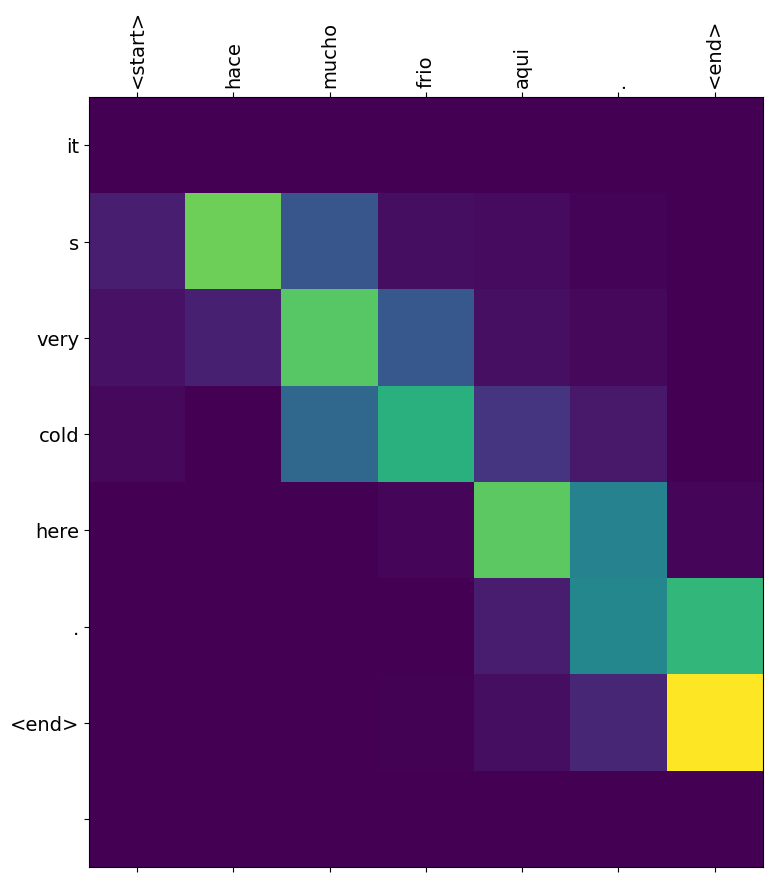

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


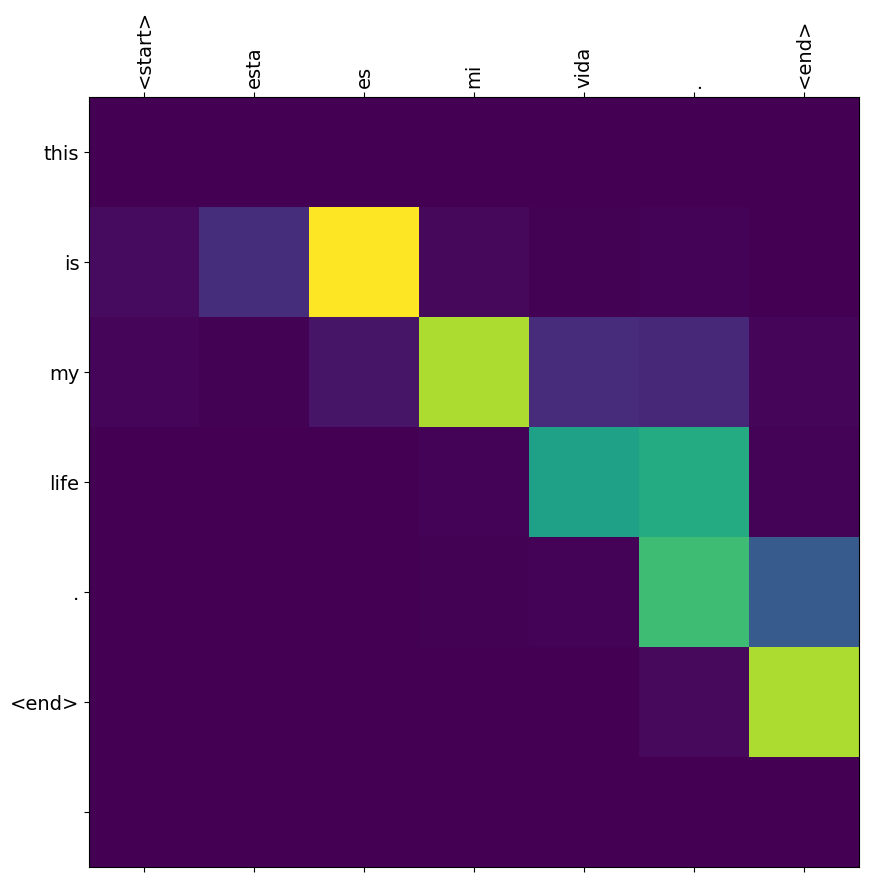

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


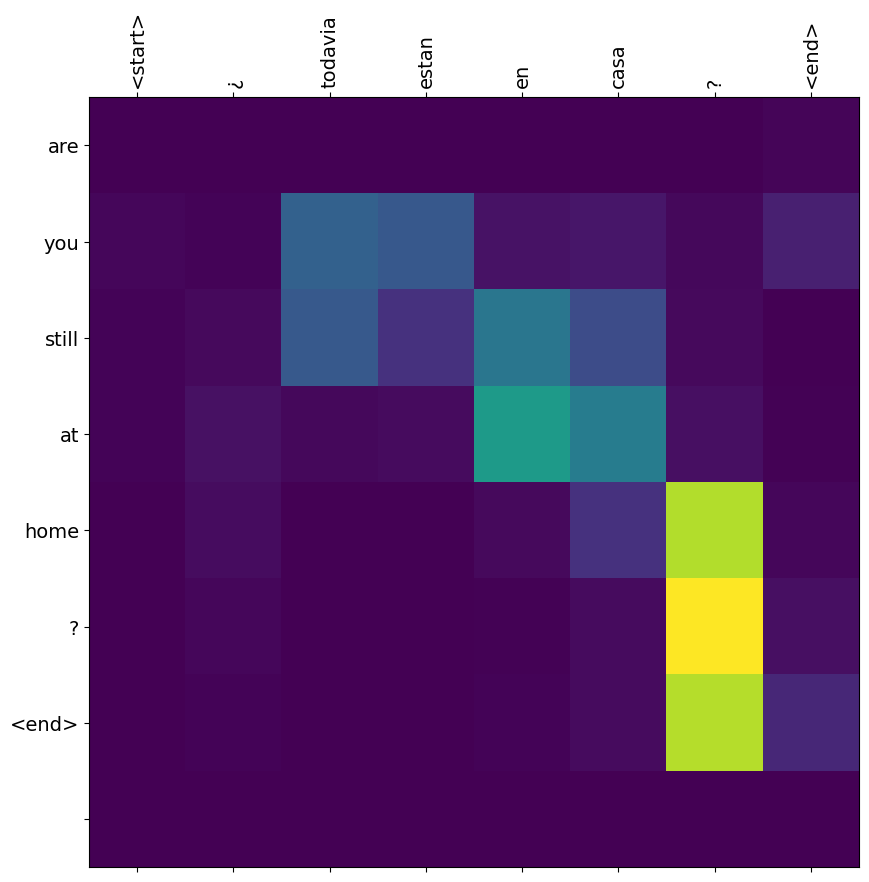

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


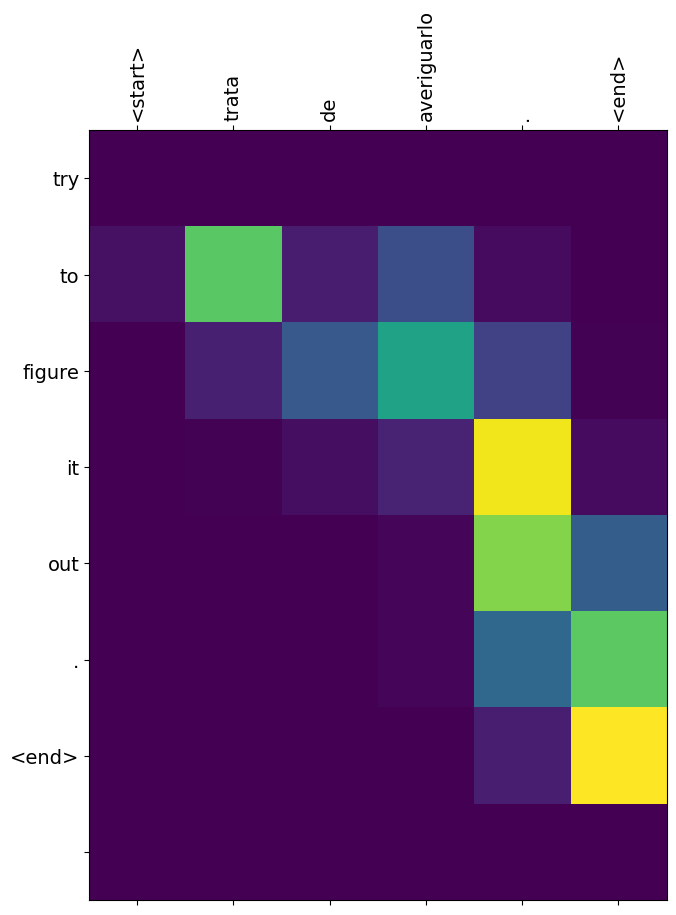

In [ ]:
# 잘못된 번역
translate(u'trata de averiguarlo.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


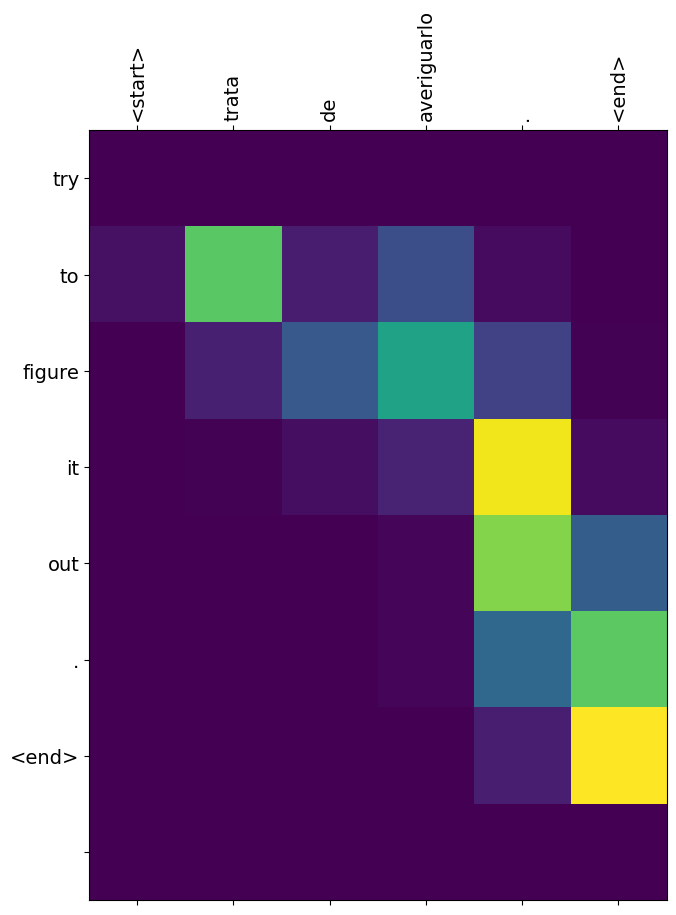

In [ ]:
# 잘못된 번역
translate(u'trata de averiguarlo.')

Input: <start> buenas noches . <end>
Predicted translation: try here night . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


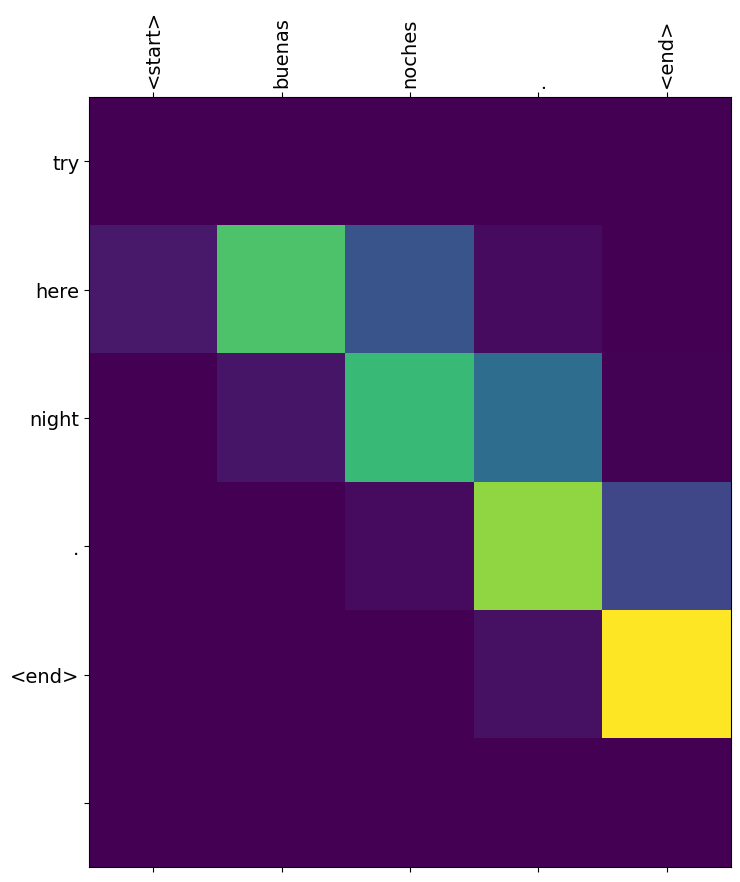

In [ ]:
# 잘못된 번역
translate(u'Buenas noches.')

Input: <start> mucho gusto . <end>
Predicted translation: it a lot to me . <end> 


<ipython-input-31-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-31-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


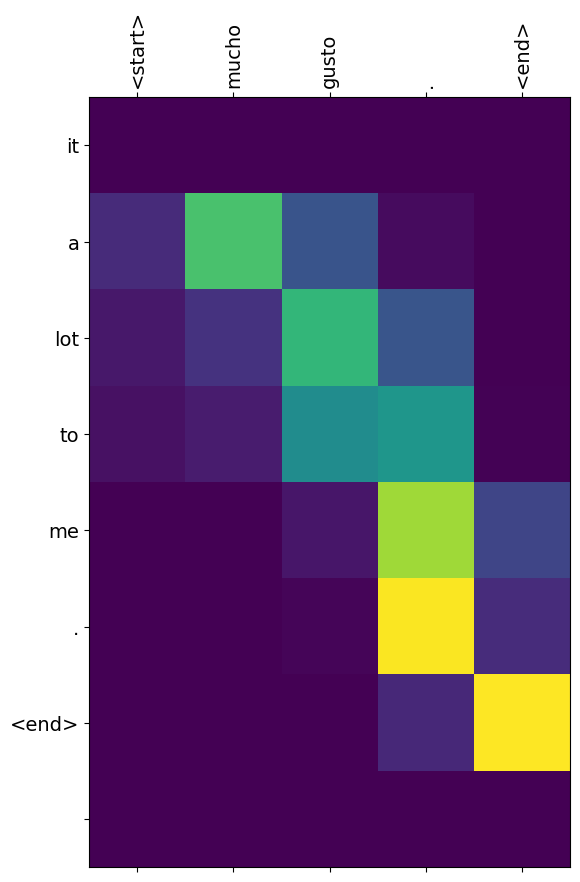

In [ ]:
# 잘못된 번역
translate(u'Mucho gusto.')

# 다음 단계

* 앞서 영어-스페인어 데이터셋을 이용해 모델을 훈련하였습니다. 이제 영어-프랑스어, 영어-한국어 등의 [댜양한 다른 언어 데이터셋](http://www.manythings.org/anki/)을 활용하여 모델을 훈련시켜 봅시다
* 또한 이 예제에서는 데이터셋을 제한하여 모델을 만들어 보았습니다. 이제 더 많은 데이터셋 혹은 더 많은 에포크(epochs)를 적용하여 모델을 훈련해봅시다


## 프랑스어

다운로드, 압축해제 등이 잘 되지 않아 새롭게 코드 수정

In [104]:
import requests
import zipfile
import os

# URL에서 파일 다운로드
url = 'http://www.manythings.org/anki/fra-eng.zip'
local_filename = 'fra-eng.zip'

def download_file(url, local_filename):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    with requests.get(url, headers=headers, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

# 압축 파일 다운로드
download_file(url, local_filename)

# 압축 해제
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall()

# 압축 해제된 파일 목록 출력
extracted_files = os.listdir()
print("Extracted files:", extracted_files)


path_to_file = os.path.abspath('fra.txt')
print("Path to 'fra.txt':", path_to_file)

Extracted files: ['.config', 'fra-eng.zip', '_about.txt', 'fra.txt', 'sample_data']
Path to 'fra.txt': /content/fra.txt


In [105]:
# 'fra.txt' 파일의 일부를 확인하기 위해 파일 읽기
file_path = 'fra.txt'

# 파일을 읽고 처음 몇 줄을 출력
with open(file_path, 'r', encoding='utf-8') as file:
    for _ in range(10):  # 처음 10줄을 출력합니다.
        line = file.readline().strip()
        print(line)

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Run!	Prenez vos jambes à vos cous !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)
Run!	File !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)


In [96]:
# 유니코드 파일을 아스키 코드 파일로 변환합니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

In [97]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :', preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : <start> have you had dinner ? <end>
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : <start> avez vous deja dine ? <end>


이 데이터에는 탭이 두 개 이상인 경우가 있어 원본 코드는 오류가 발생

In [106]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = []
    for line in lines[:num_examples]:
        parts = line.split('\t')
        if len(parts) >= 2:
            en_sentence, fr_sentence = parts[0], parts[1]
            word_pairs.append([preprocess_sentence(en_sentence), preprocess_sentence(fr_sentence)])

    return zip(*word_pairs)

In [99]:
path_to_file

'/content/fra.txt'

In [107]:
en, fr = create_dataset(path_to_file, None)
print(en[-1])
print(fr[-1])

<start> i went drinking with one of my boyfriend s friends , and now he s furious at me . was this friend a guy or a girl ? a guy , obviously . why would i go drinking with his female friends ? yeah , you re right . his name is tom . he s really hot , and i really want to go drinking with him again . <end>
<start> je suis allee boire avec un ami de mon compagnon , et voila qu il est furieux contre moi . etait ce un gars ou une fille ? un gars , bien evidemment . pourquoi irais je boire avec ses amies ? ouais , ca se comprend . il s appelle tom . il est trop canon , et j ai tellement envie d aller prendre un verre avec lui a nouveau . <end>


In [108]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding ='post')

  return tensor, lang_tokenizer

In [109]:
def load_dataset(path, num_examples = None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [110]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [111]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [112]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [113]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
57 ----> as
21 ----> tu
233 ----> froid
6 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
24 ----> are
5 ----> you
168 ----> cold
6 ----> ?
2 ----> <end>


In [114]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [115]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 9]))

In [116]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [117]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [118]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
    # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
    # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.
    # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
    query_with_time_axis = tf.expand_dims(query, 1)

    # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다.
    # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    attention_weights = tf.nn.softmax(score, axis=1)

    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [119]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [120]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 어텐션을 사용합니다.
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
    x = self.embedding(x)

    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 위에서 결합된 벡터를 GRU에 전달합니다.
    output, state = self.gru(x)

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
    output = tf.reshape(output, (-1, output.shape[2]))

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
    x = self.fc(output)

    return x, state, attention_weights

In [121]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4289)


In [122]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [123]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [124]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]):
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [125]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.1558
Epoch 1 Batch 100 Loss 2.1045
Epoch 1 Batch 200 Loss 1.9361
Epoch 1 Batch 300 Loss 1.8036
Epoch 1 Loss 2.1049
Time taken for 1 epoch 47.06737661361694 sec

Epoch 2 Batch 0 Loss 1.4329
Epoch 2 Batch 100 Loss 1.4478
Epoch 2 Batch 200 Loss 1.2506
Epoch 2 Batch 300 Loss 1.2226
Epoch 2 Loss 1.3648
Time taken for 1 epoch 24.536596536636353 sec

Epoch 3 Batch 0 Loss 1.0237
Epoch 3 Batch 100 Loss 1.0590
Epoch 3 Batch 200 Loss 0.8877
Epoch 3 Batch 300 Loss 0.8628
Epoch 3 Loss 0.9548
Time taken for 1 epoch 23.85852026939392 sec

Epoch 4 Batch 0 Loss 0.5631
Epoch 4 Batch 100 Loss 0.6381
Epoch 4 Batch 200 Loss 0.6595
Epoch 4 Batch 300 Loss 0.5199
Epoch 4 Loss 0.6444
Time taken for 1 epoch 24.7142174243927 sec

Epoch 5 Batch 0 Loss 0.4383
Epoch 5 Batch 100 Loss 0.4239
Epoch 5 Batch 200 Loss 0.4969
Epoch 5 Batch 300 Loss 0.5077
Epoch 5 Loss 0.4357
Time taken for 1 epoch 24.115729093551636 sec

Epoch 6 Batch 0 Loss 0.2731
Epoch 6 Batch 100 Loss 0.3687
Epoch 6 Batch 200 Los

In [126]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 예측된 ID를 모델에 다시 피드합니다.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [127]:
# 어텐션 가중치를 그리기 위한 함수입니다.
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [128]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [129]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> j arrete . <end>
Predicted translation: i quit . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


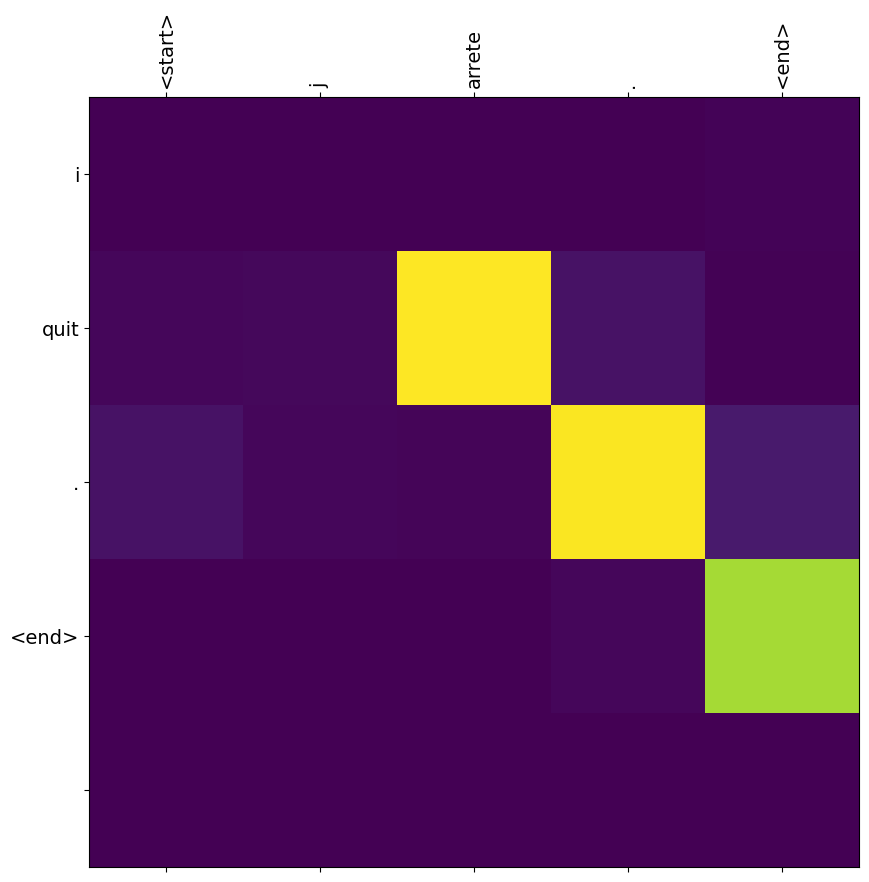

In [133]:
# 굿
translate(u"J'arrête.")

Input: <start> j ai ans . <end>
Predicted translation: i m years old . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


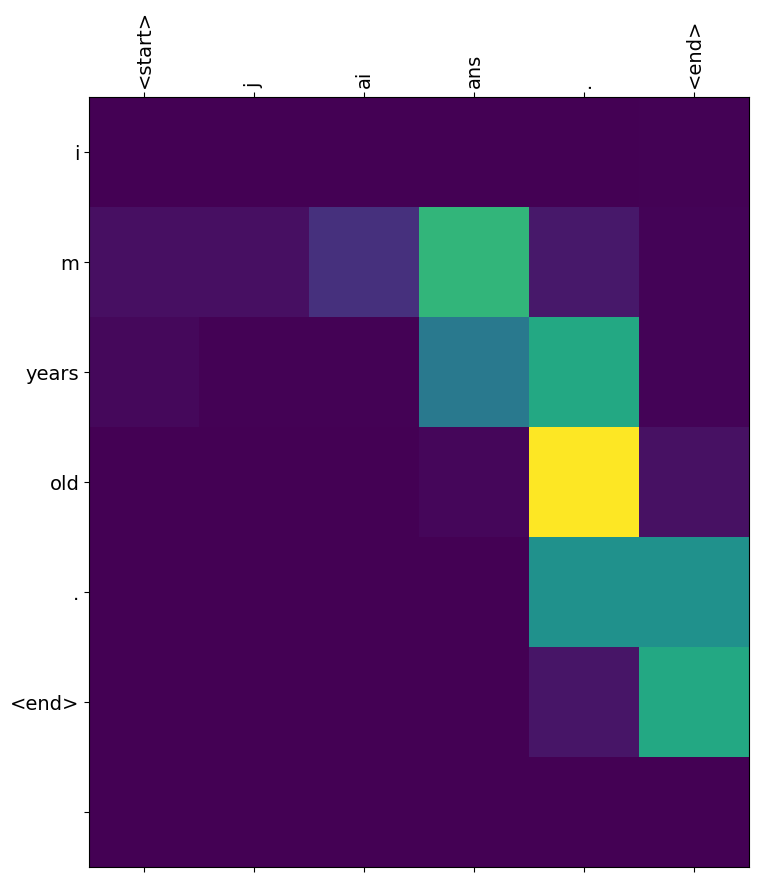

In [134]:
# 잘못된 것은 아니나, 숫자가..
translate(u"J'ai 19 ans.")

Input: <start> en aucun cas . <end>
Predicted translation: no way ! <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


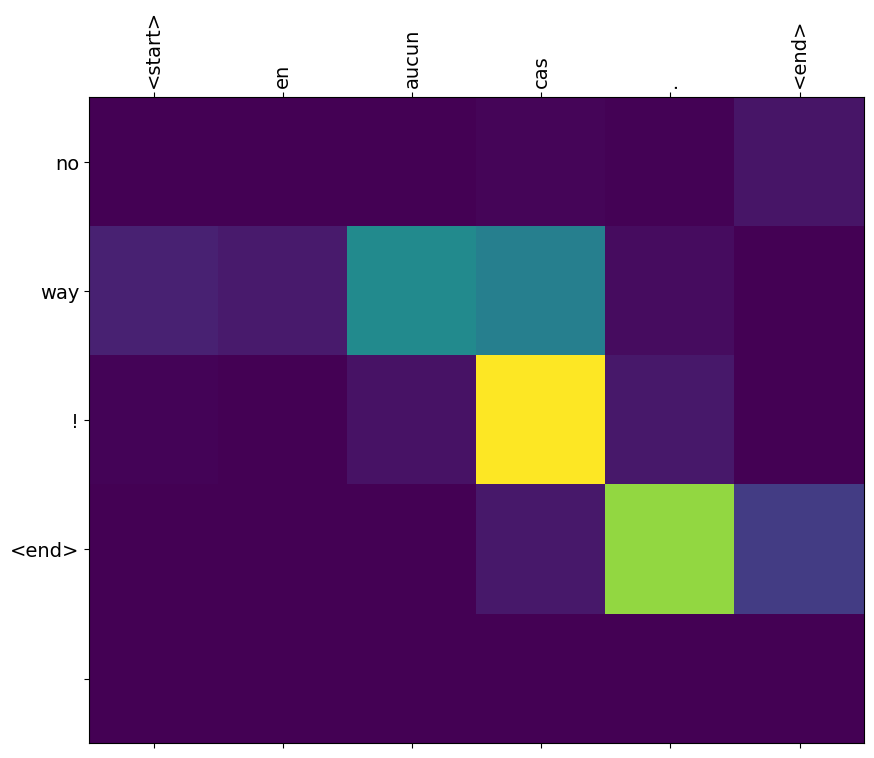

In [136]:
# 굿
translate(u"En aucun cas.")

Input: <start> je suis fou . <end>
Predicted translation: i m crazy . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


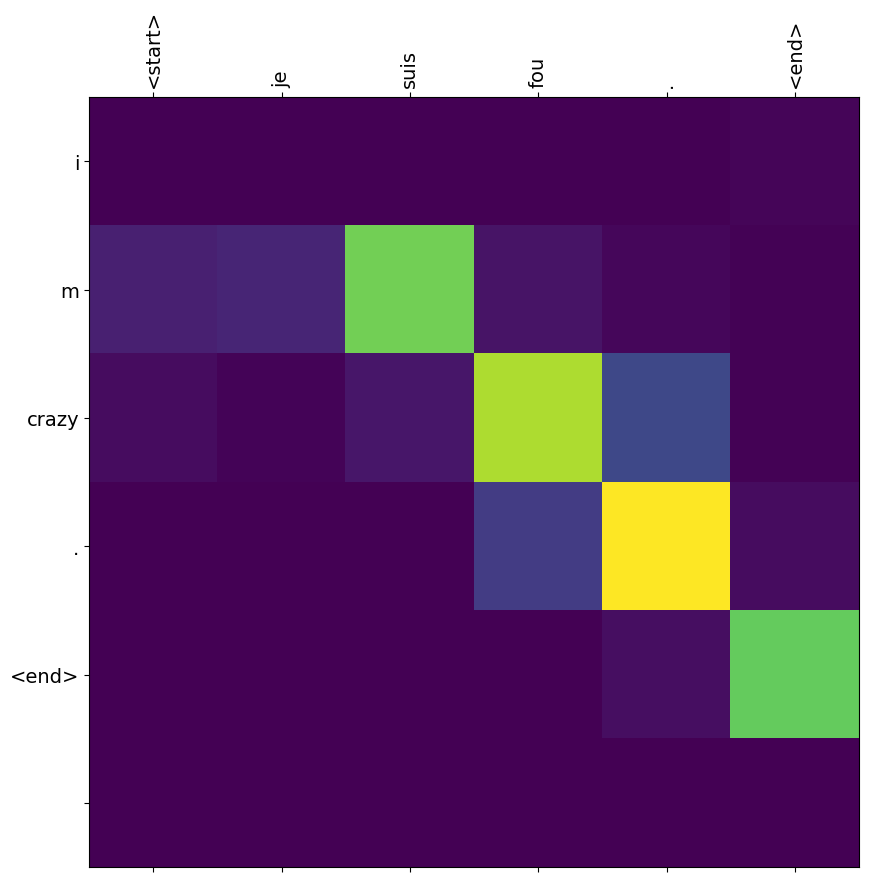

In [137]:
# 굿
translate(u"Je suis fou.")

## 한국어

In [138]:
import requests
import zipfile
import os

# URL에서 파일 다운로드
url = 'http://www.manythings.org/anki/kor-eng.zip'
local_filename = 'kor-eng.zip'

def download_file(url, local_filename):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    with requests.get(url, headers=headers, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

# 압축 파일 다운로드
download_file(url, local_filename)

# 압축 해제
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall()

# 압축 해제된 파일 목록 출력
extracted_files = os.listdir()
print("Extracted files:", extracted_files)


path_to_file = os.path.abspath('kor.txt')
print("Path to 'kor.txt':", path_to_file)

Extracted files: ['.config', 'kor.txt', 'fra-eng.zip', '_about.txt', 'fra.txt', 'training_checkpoints', 'kor-eng.zip', 'sample_data']
Path to 'kor.txt': /content/kor.txt


In [140]:
# 'kor.txt' 파일의 일부를 확인하기 위해 파일 읽기
file_path = 'kor.txt'

# 파일을 읽고 처음 몇 줄을 출력
with open(file_path, 'r', encoding='utf-8') as file:
    for _ in range(50):  # 처음 10줄을 출력합니다.
        line = file.readline().strip()
        print(line)

Go.	가.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)
Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)
Run!	뛰어!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)
Run.	뛰어.	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #8363273 (Eunhee)
Who?	누구?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #6820074 (yesjustryan)
Wow!	우와!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #8355878 (Eunhee)
Duck!	숙여!	CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #11106942 (intertime)
Fire!	쏴!	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #8355899 (Eunhee)
Help!	도와줘!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #8355885 (Eunhee)
Hide.	숨어.	CC-BY 2.0 (France) Attribution: tatoeba.org #8907581 (CK) & #11106940 (intertime)
Jump!	점프!	CC-BY 2.0 (France) Attribution: tatoeba.org #1102981 (jamessilver) & #8355893 (Eunhe

In [141]:
# 전처리 테스트
kr_sent = u"죄송합니다만?"
fr_sent = u"Sorry?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :', preprocess_sentence(en_sent))
print('전처리 전 한국어 문장 :', kr_sent)
print('전처리 후 한국어 문장 :', preprocess_sentence(kr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : <start> have you had dinner ? <end>
전처리 전 한국어 문장 : 죄송합니다만?
전처리 후 한국어 문장 : <start> ? <end>


한국어는 알파벳이 아니라 따로 전처리 정의해야

$$
\\
$$

## 포르투갈어

In [142]:
import requests
import zipfile
import os

# URL에서 파일 다운로드
url = 'http://www.manythings.org/anki/por-eng.zip'
local_filename = 'por-eng.zip'

def download_file(url, local_filename):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    with requests.get(url, headers=headers, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

# 압축 파일 다운로드
download_file(url, local_filename)

# 압축 해제
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall()

# 압축 해제된 파일 목록 출력
extracted_files = os.listdir()
print("Extracted files:", extracted_files)


path_to_file = os.path.abspath('por.txt')
print("Path to 'fra.txt':", path_to_file)

Extracted files: ['.config', 'kor.txt', 'fra-eng.zip', '_about.txt', 'por-eng.zip', 'fra.txt', 'por.txt', 'training_checkpoints', 'kor-eng.zip', 'sample_data']
Path to 'fra.txt': /content/por.txt


In [144]:
# 'fra.txt' 파일의 일부를 확인하기 위해 파일 읽기
file_path = 'por.txt'

# 파일을 읽고 처음 몇 줄을 출력
with open(file_path, 'r', encoding='utf-8') as file:
    for _ in range(30):  # 처음 10줄을 출력합니다.
        line = file.readline().strip()
        print(line)

Go.	Vai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1196331 (alexmarcelo)
Go.	Vá.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5464111 (ToinhoAlam)
Hi.	Oi.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #397074 (brauliobezerra)
Run!	Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197457 (alexmarcelo)
Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197458 (alexmarcelo)
Run!	Corram!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197503 (alexmarcelo)
Run.	Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197457 (alexmarcelo)
Run.	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197458 (alexmarcelo)
Run.	Corram!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1197503 (alexmarcelo)
Who?	Quem?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4357308 (Ricardo14)
Who?	Que	CC-BY 2.0 (France

In [159]:
# 전처리 테스트
en_sent = u"Hide."
pr_sent = u"Escondam-se"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :', preprocess_sentence(en_sent))
print('전처리 전 포르투갈어 문장 :', pr_sent)
print('전처리 후 포르투갈어 문장 :', preprocess_sentence(pr_sent))

전처리 전 영어 문장 : Hide.
전처리 후 영어 문장 : <start> hide . <end>
전처리 전 포르투갈어 문장 : Escondam-se
전처리 후 포르투갈어 문장 : <start> escondam se <end>


In [160]:
en, pr = create_dataset(path_to_file, None)
print(en[-1])
print(pr[-1])

<start> using high heat settings while ironing synthetic fabrics will melt the synthetic fibers and cause visible permanent damage , which often looks like a shiny area where the too hot iron had the longest contact with the fabric . <end>
<start> a utilizacao de niveis elevados de calor ao passar a ferro tecidos sinteticos derretera as fibras sinteticas e causara danos visiveis permanentes , que muitas vezes tem a aparencia de uma area reluzente onde o ferro demasiado quente esteve mais tempo em contacto com a malha . <end>


In [148]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [149]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> o
5 ----> tom
3809 ----> recebeu
14 ----> um
3368 ----> bonus
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
67 ----> got
11 ----> a
2267 ----> bonus
3 ----> .
2 ----> <end>


In [150]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 14]), TensorShape([64, 10]))

In [151]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 14, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [152]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 14, 1)


In [153]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4161)


In [154]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [155]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [156]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]):
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [157]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7659
Epoch 1 Batch 100 Loss 2.1317
Epoch 1 Batch 200 Loss 1.8793
Epoch 1 Batch 300 Loss 1.5402
Epoch 1 Loss 1.9353
Time taken for 1 epoch 52.82483220100403 sec

Epoch 2 Batch 0 Loss 1.5533
Epoch 2 Batch 100 Loss 1.3448
Epoch 2 Batch 200 Loss 1.2748
Epoch 2 Batch 300 Loss 1.2019
Epoch 2 Loss 1.2336
Time taken for 1 epoch 41.54998016357422 sec

Epoch 3 Batch 0 Loss 0.9203
Epoch 3 Batch 100 Loss 0.9568
Epoch 3 Batch 200 Loss 0.8489
Epoch 3 Batch 300 Loss 0.7646
Epoch 3 Loss 0.8660
Time taken for 1 epoch 24.140972137451172 sec

Epoch 4 Batch 0 Loss 0.5734
Epoch 4 Batch 100 Loss 0.5907
Epoch 4 Batch 200 Loss 0.5271
Epoch 4 Batch 300 Loss 0.5063
Epoch 4 Loss 0.5777
Time taken for 1 epoch 26.488606929779053 sec

Epoch 5 Batch 0 Loss 0.3632
Epoch 5 Batch 100 Loss 0.3079
Epoch 5 Batch 200 Loss 0.3820
Epoch 5 Batch 300 Loss 0.3499
Epoch 5 Loss 0.3773
Time taken for 1 epoch 24.08457922935486 sec

Epoch 6 Batch 0 Loss 0.2561
Epoch 6 Batch 100 Loss 0.2196
Epoch 6 Batch 200 Lo

In [158]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Wow!	Nossa!

Stay.	Fiquem.

Hide.	Escondam-se.

Hide.	Se esconda.

Input: <start> escondam se <end>
Predicted translation: drive on . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


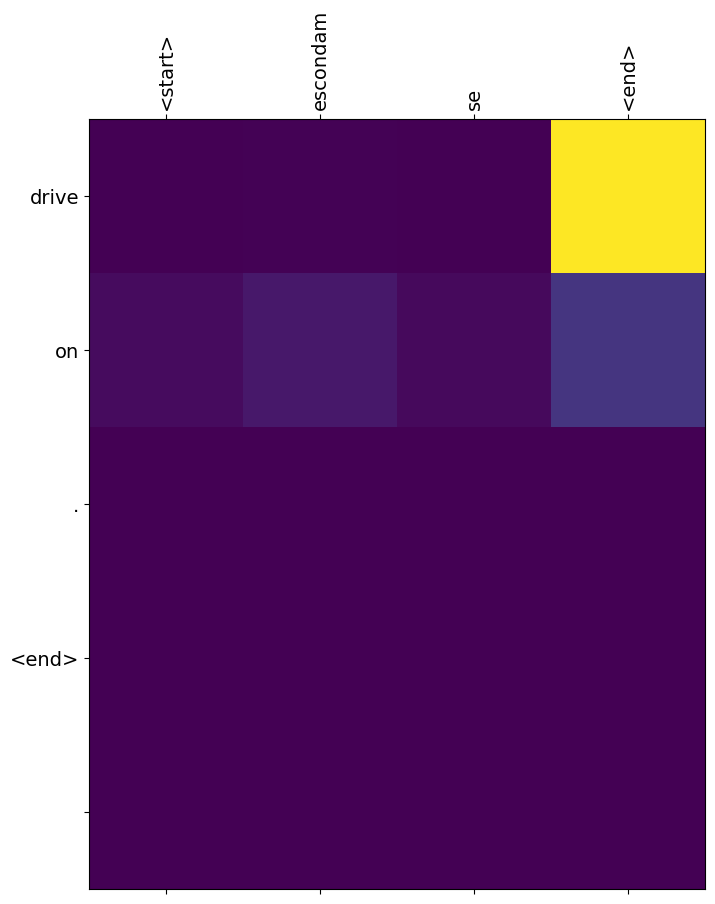

In [161]:
# 엥
translate(u"Escondam-se")

Input: <start> fiquem . <end>
Predicted translation: stay . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


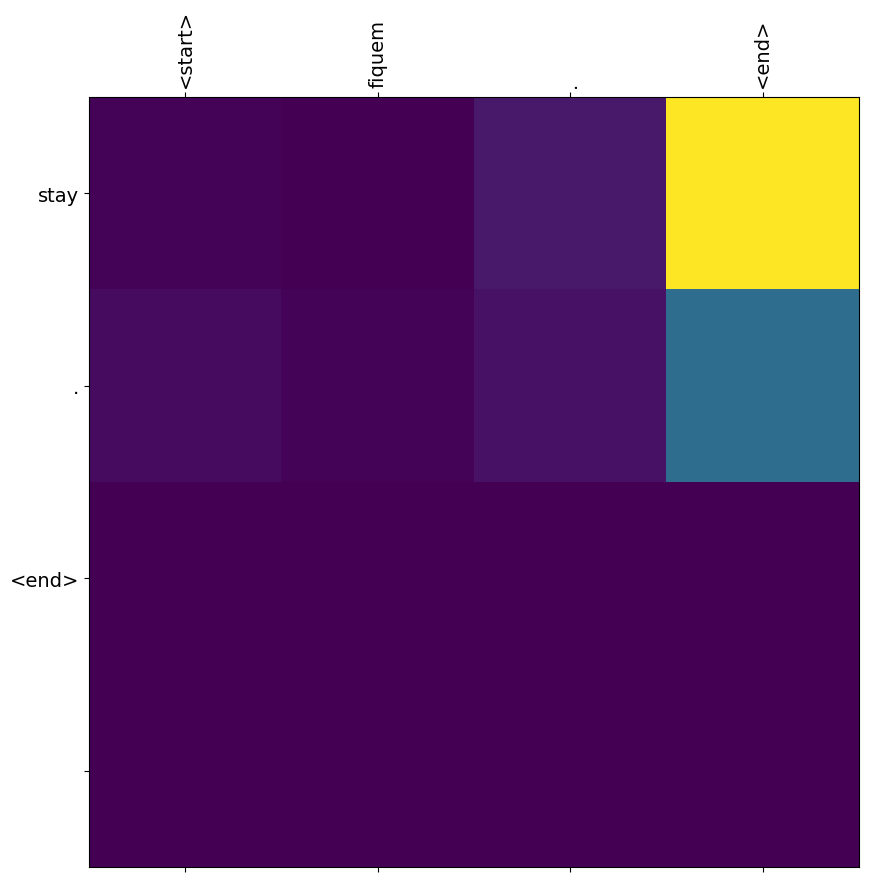

In [162]:
# 굿
translate(u"Fiquem.")

Input: <start> nossa ! <end>
Predicted translation: wow ! <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


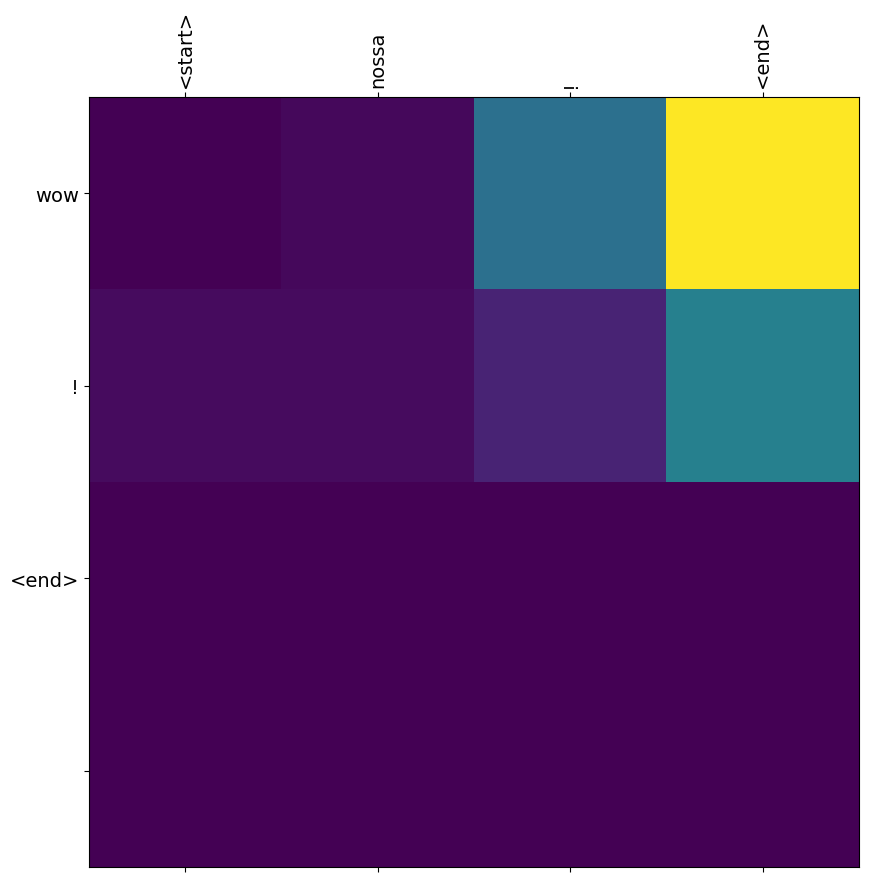

In [163]:
# 굿
translate(u"Nossa!")

Input: <start> se esconda . <end>
Predicted translation: keep hard . <end> 


<ipython-input-127-833ef93d3930>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-127-833ef93d3930>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


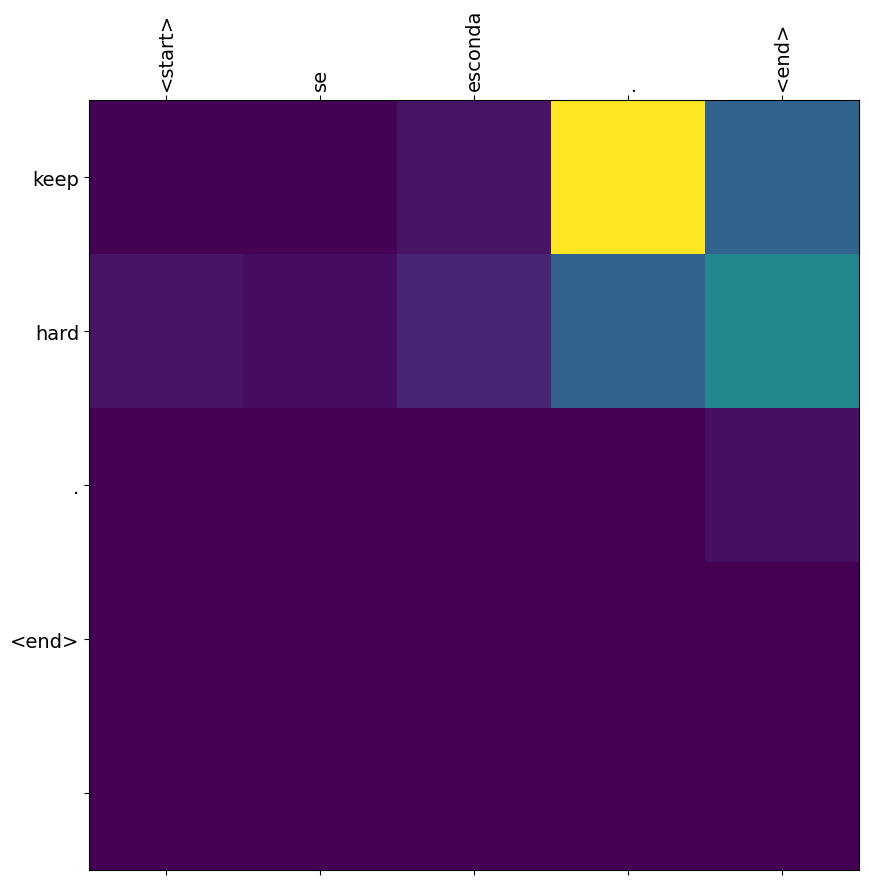

In [164]:
# 엥
translate(u"Se esconda.")

# 코멘트

1. 데이터 불러오는 작업, 전처리 작업만 잘 신경쓰면 모델 구현 자체는 어렵지 않을 것 같다.

- 데이터마다 양식이나 '구분자'가 다르다는 점

- 언어마다 전처리 (특히 한국어) 다르다는 점

2. 숫자는 어떻게 해야하지?

3. 한국어, 일본어의 경어 표현 등은 어떻게?

4. epoch을 더 길게 한다고 해서 성능이 그렇게 좋아지지는 않았던 것 같음. 짧게 설정해도 빠르게 성능이 개선

5. 문맥에 따라 다른 의미를 가지는 경우는?